In [1]:
from __future__ import print_function, division
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv, find_dotenv
%matplotlib inline

print('sys_version', sys.version.replace('\n', ''))
print('virtual_env', os.environ.get('VIRTUAL_ENV', 'None'))
print('pwd', os.getcwd())
print('np ', np.__version__)
print('pd ', pd.__version__)

load_dotenv(find_dotenv())

sys_version 3.5.2 (default, Nov 17 2016, 17:05:23) [GCC 5.4.0 20160609]
virtual_env None
pwd /home/marko/nmiculinic/minion/notebook
np  1.11.1
pd  0.19.2


/usr/local/lib/python3.5/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/usr/local/lib/python3.5/dist-packages/dotenv/main.py:24: UserWarning: Not loading  - it doesn't exist.
  warnings.warn("Not loading %s - it doesn't exist." % dotenv_path)


In [2]:
from mincall.bioinf_utils import error_rates_for_sam, error_positions_report, CIGAR_OPERATIONS

In [3]:
# example sam path
path = '/home/marko/bioinf/samscripts/src/resdeep9891988_lambda.sam'

## Error rates

In [4]:
df = error_rates_for_sam(path)
df.describe(percentiles=[])

,Error rate,Match rate,Mismatch rate,Insertion rate,Deletion rate,Read length
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,0.303575,0.870113,0.094832,0.035054,0.173688,5094.635294
std,0.121899,0.050690,0.036100,0.019210,0.083177,2582.182566
min,0.150568,0.649657,0.039773,0.014881,0.065269,360.000000
50%,0.248053,0.890566,0.076032,0.032113,0.147931,5171.000000
max,0.581709,0.934659,0.212490,0.137852,0.385950,11302.000000


## CIGAR operations - position analysis

In [5]:
position_report = error_positions_report(path, n_buckets=500)
position_report.head()

,relative_position,operation,op_count
0,0.0,S,270
1,0.0,X,125
2,0.0,I,178
3,0.0,D,19
4,0.0,=,464


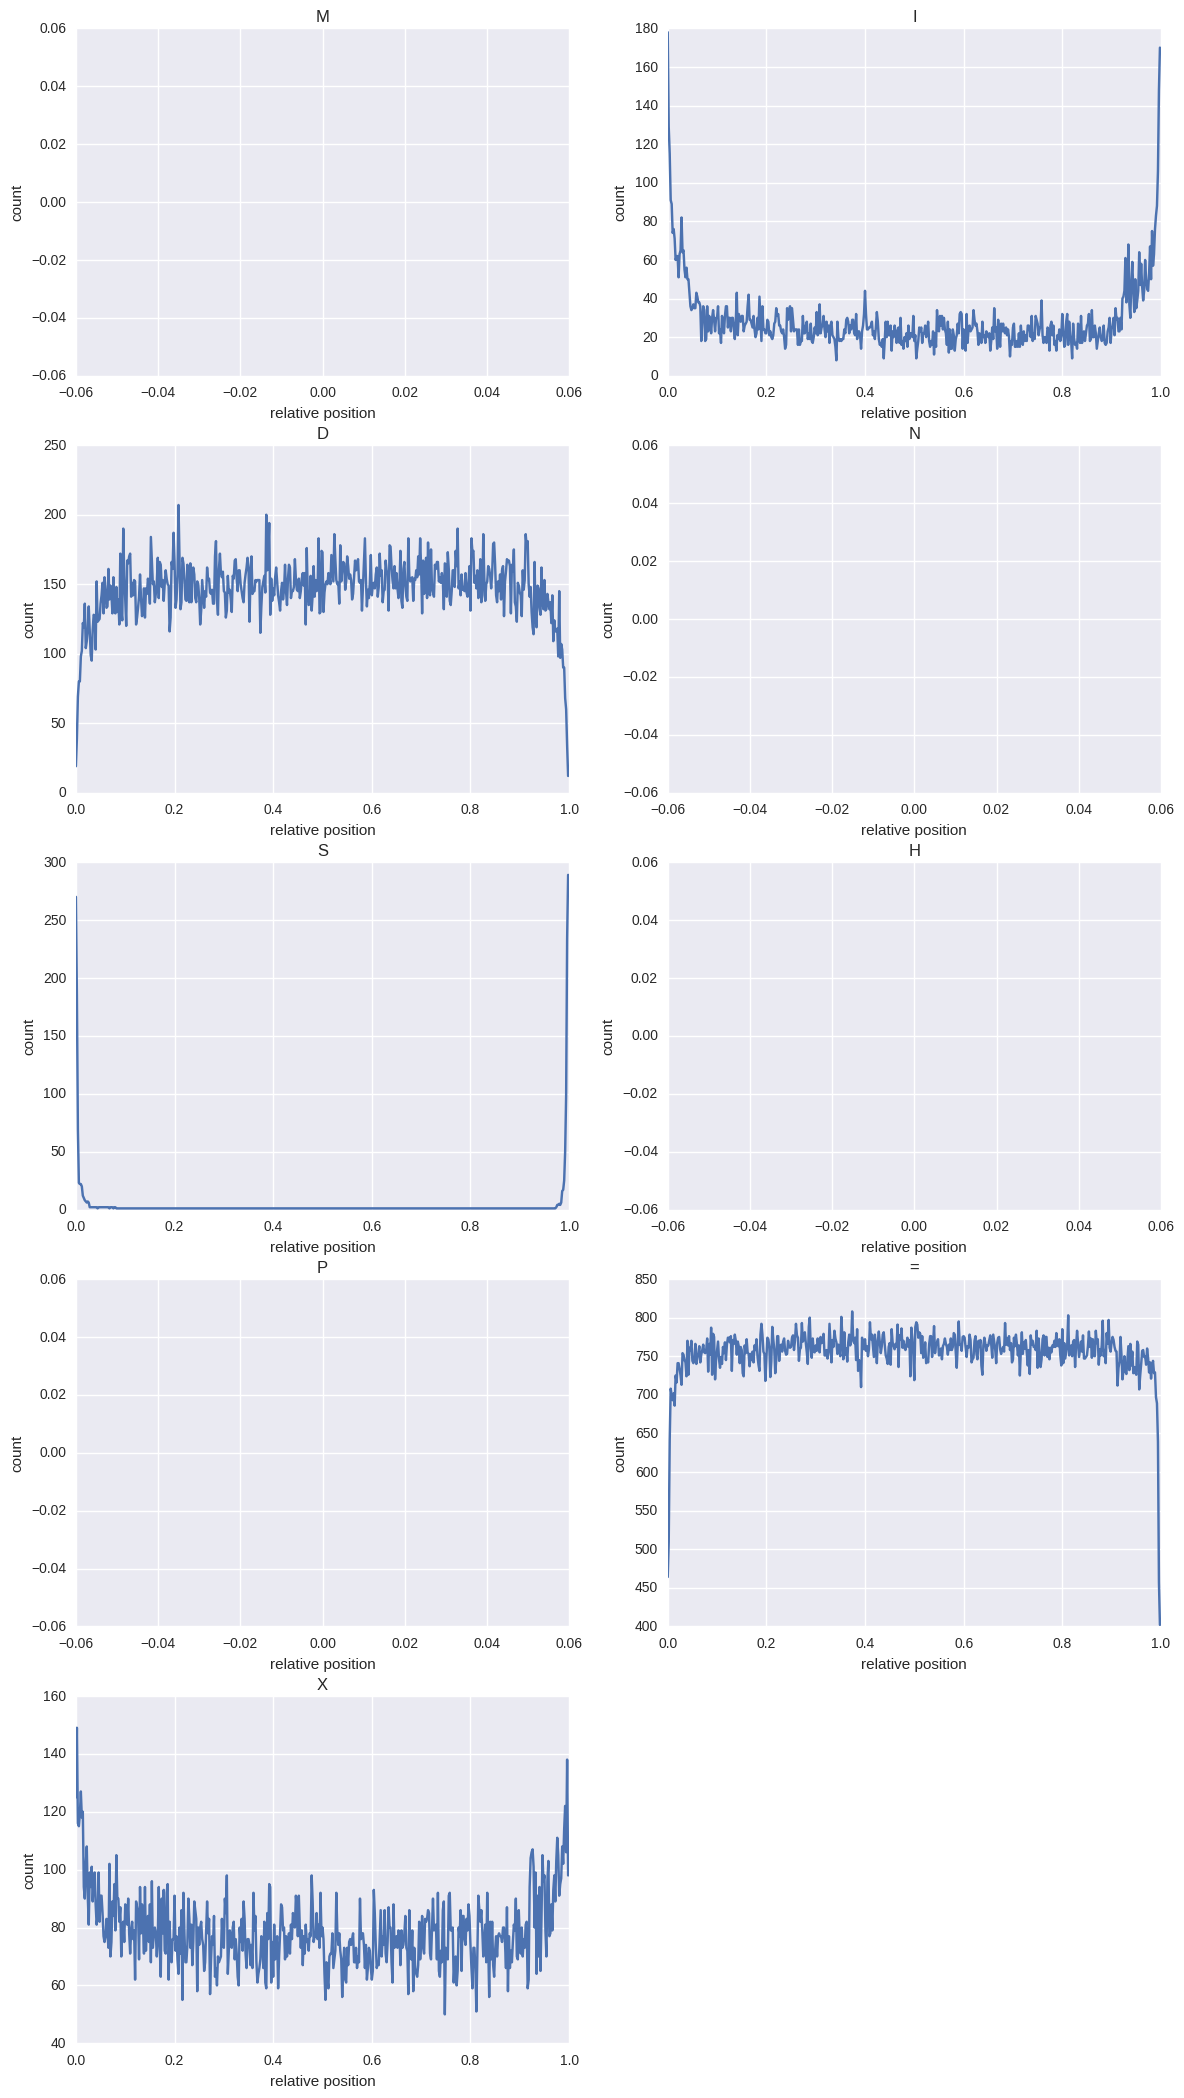

In [6]:
plt.figure(figsize=(14,26))

n_graphs = len(CIGAR_OPERATIONS)
n_cols = 2
n_rows = np.ceil(n_graphs/2)


for i, op in enumerate(CIGAR_OPERATIONS):
    data = position_report[position_report.operation == op]

    plt.subplot(n_rows, n_cols, i+1)
    plt.plot(data.relative_position, data.op_count)

    plt.xlabel('relative position')
    plt.ylabel('count')
    plt.title(op)


## Consensus stats